In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

# Read

In [2]:
DARTs = [21414, 21419, 21401, 21418, 21413, 52403, 52406, 55012, 51425, 51407,
        46404, 46407, 46411, 46412, 43412, 43413, 32411, 32412,32413,32401]
# DARTs = [ 52403, 52406]
dataFrames = {}

In [3]:
len(DARTs)

20

In [4]:
for i,dartNumber in enumerate(DARTs):
    params = {
        'filepath_or_buffer': 'dart{}'.format(dartNumber),
        'skiprows': 2,
        'delim_whitespace': True,
        'names' : 'year month day hour minute second T height'.split(),
        'na_values': 9999
    }
    df = pd.read_csv(**params)
    df['date'] = pd.to_datetime(df['year month day hour minute second'.split()])
    df = df['date height'.split()]
    
    df = df.set_index('date')
    df = df.interpolate()
    dataFrames[dartNumber] = df
    

In [5]:
skipBuoys = [32401, 32413, 43413, 52406, 21401, 21419, 21414]

In [6]:
DARTs = [dart for dart in DARTs if dart not in skipBuoys]

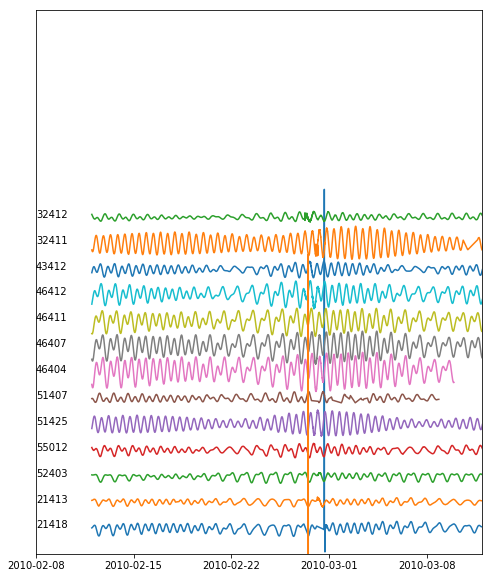

In [7]:
plt.figure(figsize=(8,10))
for i,dart in enumerate(DARTs):
    df = dataFrames[dart]
    plt.plot(df['height']-df['height'].mean()+i*2)
    plt.text(df.index.min()-pd.Timedelta(days=4),i*2,'{}'.format(dart))
    plt.ylim(-2,40)
    plt.xlim(df.index.min()-pd.Timedelta(days=4), df.index.max())
    plt.gca().set_yticks([])

# Apply high freq band filter

In [8]:
def interpolateToUniformStep(df2):
#     df = df2.iloc[np.where(1-np.isnan(df2))[0]]
    df = df2.dropna()
    t0 = df.index.to_julian_date()

    dt = np.unique(np.diff(t0[::-1]))[1:].min()
    #assuming dt in days need it in seconds
#     dt = max(dt, 0.1)
    
    t = np.arange(t0.min(),t0.max()+dt,dt)
    print('original tseries shape=',t.shape)
    npower2 = int(np.ceil(np.log2(t.shape[0])))
    t = np.linspace(t0.min(),t0.max(),2**npower2)
    dt = np.diff(t)[0]
    
    print('interpolating with dt = {} days  = {} seconds'.format(dt,dt*24*60*60))
    print('and shape = ',t.shape)

    h = np.interp(t,t0[::-1],df['height'][::-1])
    return dt, t,h

In [9]:
def filterSignal(h,cut,dt):
    
    print('taking fft of signal with shape:', h.shape)
    a = np.fft.fft(h)
    freq = np.fft.fftfreq(h.shape[0],d=dt)
    alow = np.where(np.abs(freq)<=cut,a,0.0)
    ahigh = np.where(np.abs(freq)>cut,a,0.0)
    print('getting low freq signal')
    hlow = np.fft.ifft(alow)
    print('getting high freq signal')
    hhigh = np.fft.ifft(ahigh)
    print('done')
    nonzerolow = np.where(np.abs(alow)>1e-5)[0]
    nonzerohigh = np.where(np.abs(ahigh)>1e-5)[0]
    lowSignal = {
        'a': alow[nonzerolow],
        'h': hlow,
        'freq': freq[nonzerolow]
    }
    
    highSignal = {
        'a': ahigh[nonzerohigh],
        'h': hhigh,
        'freq': freq[nonzerohigh]
    }
    return lowSignal, highSignal

In [10]:
def getFilteredSignal(df,cut):
    dt, t,h = interpolateToUniformStep(df)
    lowSignal, highSignal = filterSignal(h,cut,dt)
    return lowSignal, highSignal, t, h

In [11]:
filteredSignals = {}

In [12]:
threshold = {}
for key in dataFrames.keys():
    threshold[key] = 3.0

In [13]:
threshold[46407]= 10.0

In [14]:
for key in DARTs:
    print('\n{}'.format(key))
    lowSignal,highSignal, t, h = getFilteredSignal(dataFrames[key], threshold[key])
    filteredSignals[key] = {
        'lowSignal': lowSignal,
        'highSignal': highSignal, 
        't': t, 
        'h': h
    }


21418
original tseries shape= (40322,)
interpolating with dt = 0.0004272526130080223 days  = 36.91462576389313 seconds
and shape =  (65536,)
taking fft of signal with shape: (65536,)
getting low freq signal
getting high freq signal
done

21413
original tseries shape= (161282,)
interpolating with dt = 0.00010681198909878731 days  = 9.228555858135223 seconds
and shape =  (262144,)
taking fft of signal with shape: (262144,)
getting low freq signal
getting high freq signal
done

52403
original tseries shape= (161282,)
interpolating with dt = 0.00010681198909878731 days  = 9.228555858135223 seconds
and shape =  (262144,)
taking fft of signal with shape: (262144,)
getting low freq signal
getting high freq signal
done

55012
original tseries shape= (161282,)
interpolating with dt = 0.00010681198909878731 days  = 9.228555858135223 seconds
and shape =  (262144,)
taking fft of signal with shape: (262144,)
getting low freq signal
getting high freq signal
done

51425
original tseries shape= (1612

In [15]:
map(lambda k: k, dataFrames.keys())

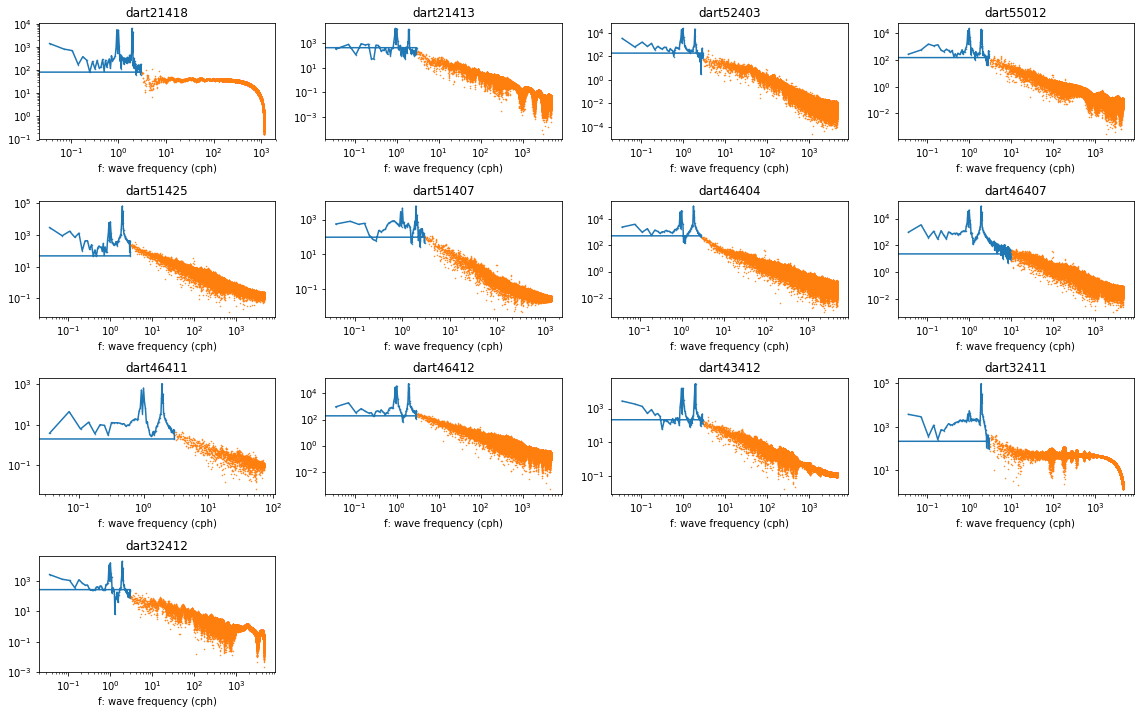

In [16]:
plt.figure(figsize=(16,12))
for i,dart in enumerate(DARTs):

    lowSignal,highSignal, t, h = (filteredSignals[dart]['lowSignal'],
                            filteredSignals[dart]['highSignal'],
                            filteredSignals[dart]['t'],
                            filteredSignals[dart]['h'] )

    plt.subplot(5,4,i+1)
    plt.plot(lowSignal['freq'][1:],np.abs(lowSignal['a'])[1:],'.-',ms=1)
    plt.plot(highSignal['freq'][1:],np.abs(highSignal['a'])[1:],'.',ms=1)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('f: wave frequency (cph)')
    plt.title('dart{}'.format(dart))
#     plt.ylim(4,14)
plt.tight_layout()
# plt.savefig('dart-spectra.png',dpi=300)

In [17]:
earthquakeDate = pd.to_datetime('2010-02-27 06:34:11 ')
tearthquake = earthquakeDate.to_julian_date()

In [18]:
plt.close('all')

In [19]:
lowSignal['h'].real.shape

(262144,)

In [20]:
filteredSignals.keys()

dict_keys([21418, 21413, 52403, 55012, 51425, 51407, 46404, 46407, 46411, 46412, 43412, 32411, 32412])

(0, 24)

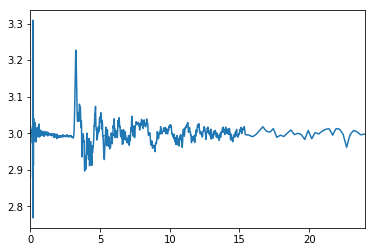

In [21]:
lowSignal,highSignal, t, h = (filteredSignals[dart]['lowSignal'],
                        filteredSignals[dart]['highSignal'],
                        filteredSignals[dart]['t'],
                        filteredSignals[dart]['h'] )
lowSignal['h'].real = lowSignal['h'].real - lowSignal['h'].real.mean() 
df = dataFrames[dart]
plt.plot((t-tearthquake)*24,highSignal['h'].real+i*0.25)
plt.xlim(0,24)

21418


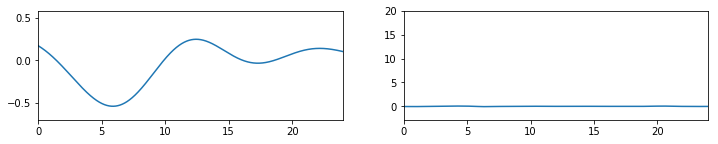

21413


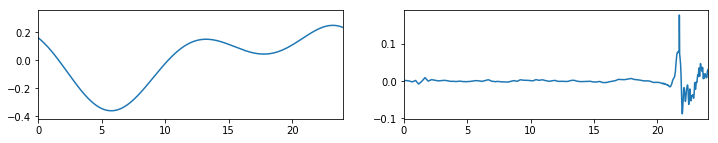

52403


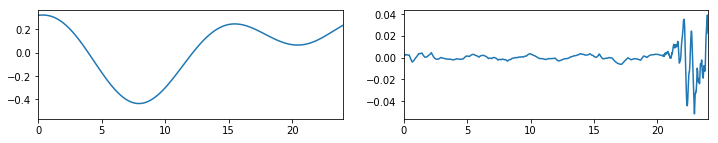

55012


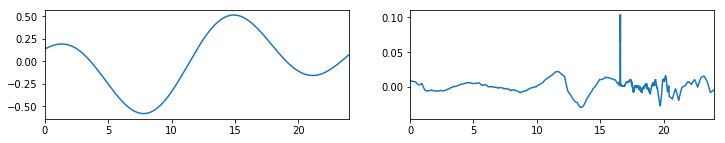

51425


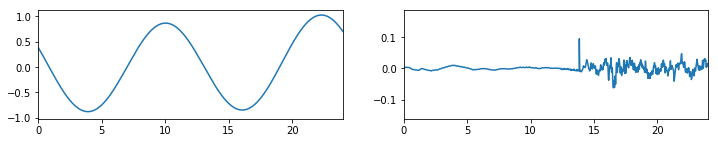

51407


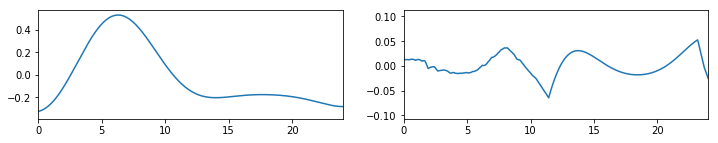

46404


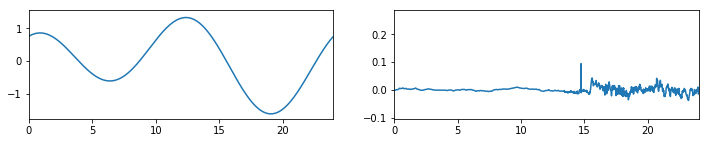

46407


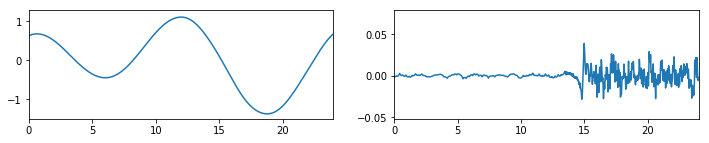

46411


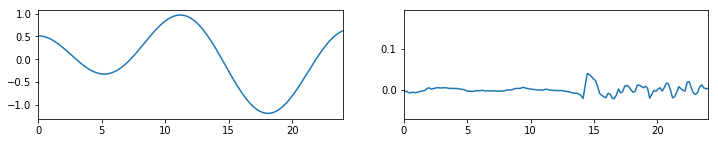

46412


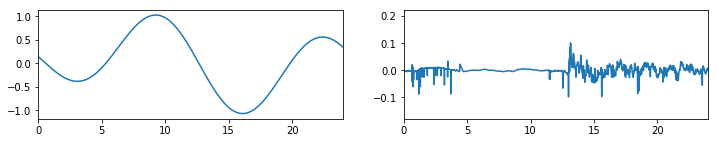

43412


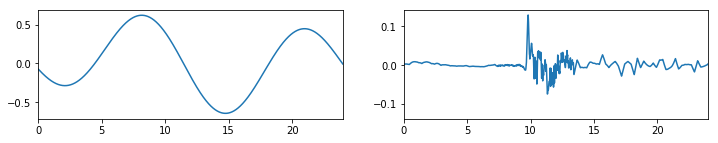

32411


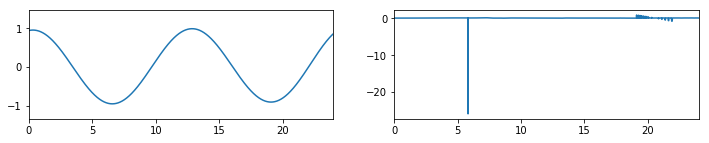

32412


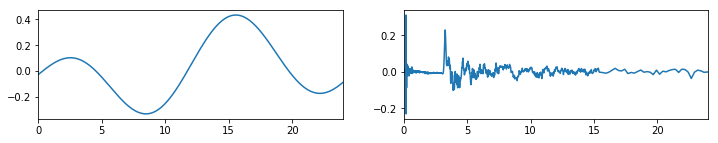

[]

In [22]:
for i,dart in enumerate(DARTs):
    lowSignal,highSignal, t, h = (filteredSignals[dart]['lowSignal'],
                            filteredSignals[dart]['highSignal'],
                            filteredSignals[dart]['t'],
                            filteredSignals[dart]['h'] )
    lowSignal['h'].real = lowSignal['h'].real - lowSignal['h'].real.mean() 
    df = dataFrames[dart]
    
    plt.figure(figsize=(12,2))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.plot((t-tearthquake)*24,lowSignal['h'].real)
    ax2.plot((t-tearthquake)*24,highSignal['h'].real)
    
    print( '{}'.format(dart))
    
    ax1.set_xlim(0,24)
    ax2.set_xlim(0,24)

    plt.show()

ax2.set_yticks([])

In [23]:
for dart in DARTs:
    lowSignal,highSignal, t, h = (filteredSignals[dart]['lowSignal'],
                            filteredSignals[dart]['highSignal'],
                            filteredSignals[dart]['t'],
                            filteredSignals[dart]['h'] )
    
    fout = 'tsunamiDART{}'.format(dart)
    print(fout)
    np.savetxt(fout,np.vstack([t-tearthquake,highSignal['h'].real]).T)

tsunamiDART21418
tsunamiDART21413
tsunamiDART52403
tsunamiDART55012
tsunamiDART51425
tsunamiDART51407
tsunamiDART46404
tsunamiDART46407
tsunamiDART46411
tsunamiDART46412
tsunamiDART43412
tsunamiDART32411
tsunamiDART32412
